In [16]:
import numpy as np
import random
import os
import shutil

# ! pip install split-folders
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

rs = 42
def reset_random_seeds(rs):
   os.environ['PYTHONHASHSEED']=str(rs)
   tf.random.set_seed(rs)
   np.random.seed(rs)
   random.seed(rs)
reset_random_seeds(rs)

map_dir = 'map 5'

remove prev saved database:

In [17]:
dir_path = './data/humanModel_v1_dataset_split'
if os.path.exists(dir_path):
    # shutil.rmtree(dir_path)
    print("Database exists")
else:
    print("File not found in the directory")

Database exists


# Part 1 - Data Preprocessing

## Split into train , test data

In [18]:
# train, test split
splitfolders.ratio('./data/humanModel_v1_dataset/action_target', output="./data/humanModel_v1_dataset_split/action_target", ratio=(0.8, 0.2))
splitfolders.ratio('./data/humanModel_v1_dataset/rate_target', output="./data/humanModel_v1_dataset_split/rate_target", ratio=(0.8, 0.2))

Copying files: 1056 files [00:00, 13497.19 files/s]
Copying files: 1056 files [00:00, 14296.46 files/s]


### Preprocessing the Training set

In [19]:
batch_size = 64
IMG_SIZE = 10

datagen = ImageDataGenerator(rescale = 1./255)
train = datagen.flow_from_directory('./data/humanModel_v1_dataset_split/action_target/train',
                                            target_size = (IMG_SIZE,IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

test = datagen.flow_from_directory('./data/humanModel_v1_dataset_split/action_target/val',
                                            target_size = (IMG_SIZE, IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

train = datagen.flow_from_directory('./data/humanModel_v1_dataset_split/rate_target/train',
                                            target_size = (IMG_SIZE,IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

test = datagen.flow_from_directory('./data/humanModel_v1_dataset_split/rate_target/val',
                                            target_size = (IMG_SIZE, IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

Found 843 images belonging to 5 classes.
Found 213 images belonging to 5 classes.
Found 842 images belonging to 7 classes.
Found 214 images belonging to 7 classes.


## View some data

In [21]:
# num_classes = 5

# model = Sequential([
#   layers.Conv2D(8, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=[IMG_SIZE,IMG_SIZE,3]),
#   layers.Conv2D(16, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#   layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#   layers.MaxPooling2D(),
#   layers.Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#   layers.Dropout(0.5),
#   layers.Flatten(),
#   layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#   layers.Dense(num_classes, activation='softmax')
# ])

# Define model layers.
input_layer = Input(shape=(IMG_SIZE,IMG_SIZE,3))
X = Conv2D(8, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)
X = Conv2D(16, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(X)
X = Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(X)
X = MaxPooling2D()(X)
X = Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(X)
X = Dropout(0.5)(X)
X = Flatten()(X)
X = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(X)

# action output will be fed from the first dense
action_output = Dense(units='1', name='action_output')(X)
# rate output will be fed from the second dense
rate_output = Dense(units='1',name='rate_output')(X)

# Define the model with the input layer 
# and a list of output layers
model = Model(inputs=input_layer,outputs=[action_output, rate_output])

In [24]:
model.compile(optimizer='adam',
            loss={'action_output': 'mse', 'rate_output': 'mse'},
            #   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            #   metrics=['accuracy'])
            metrics={'action_output':tf.keras.metrics.RootMeanSquaredError(),
                    'rate_output':tf.keras.metrics.RootMeanSquaredError()})

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 10, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 10, 10, 8)    392         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 10, 10, 16)   2064        conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 10, 10, 16)   2320        conv2d_5[0][0]                   
______________________________________________________________________________________________

In [ ]:
epochs=200
history = model.fit(
  train,
  validation_data=test,
  epochs=epochs
)

Epoch 1/200


2022-03-13 17:03:36.973598: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/home/ido/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '
2022-03-13 17:03:37.602675: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302


14/14 [==============================] - 1s 23ms/step - loss: nan - accuracy: 0.2827 - val_loss: nan - val_accuracy: 0.2850
Epoch 2/200
14/14 [==============================] - 0s 14ms/step - loss: nan - accuracy: 0.2874 - val_loss: nan - val_accuracy: 0.2850
Epoch 3/200
14/14 [==============================] - 0s 11ms/step - loss: nan - accuracy: 0.2874 - val_loss: nan - val_accuracy: 0.2850
Epoch 4/200
14/14 [==============================] - 0s 11ms/step - loss: nan - accuracy: 0.2874 - val_loss: nan - val_accuracy: 0.2850
Epoch 5/200
14/14 [==============================] - 0s 11ms/step - loss: nan - accuracy: 0.2874 - val_loss: nan - val_accuracy: 0.2850
Epoch 6/200
14/14 [==============================] - 0s 11ms/step - loss: nan - accuracy: 0.2874 - val_loss: nan - val_accuracy: 0.2850
Epoch 7/200
14/14 [==============================] - 0s 11ms/step - loss: nan - accuracy: 0.2874 - val_loss: nan - val_accuracy: 0.2850
Epoch 8/200
14/14 [==============================] - 0s 11ms

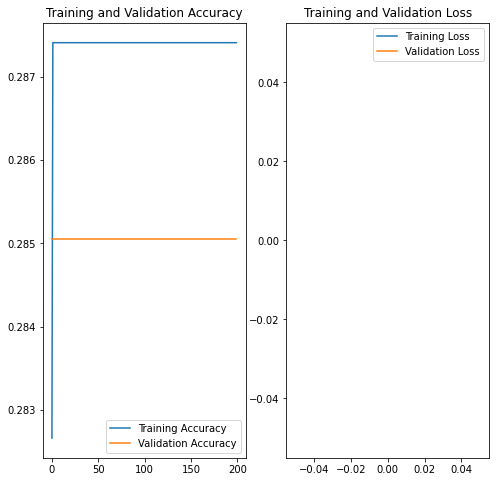

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test)
print('Test accuracy :', accuracy)

4/4 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.2850
Test accuracy : 0.2850467264652252


In [ ]:
# Save the entire model as a SavedModel.
# model.save('./data/humanModel/mode_v0')
model.save('./data/'+map_dir+'/humanModel_v1.h5')

In [ ]:
# save model in js format
# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model, 'data/humanModel/js_model_v0')

In [ ]:
# new_model = tf.keras.models.load_model('./data/humanModel/mode_v0')

# # Check its architecture
# new_model.summary()

### Predict on new data

In [ ]:
path = "./data/humanModel_v1_dataset_split/val/32_1/-Ms8jLrHMPiQF4tLfvKR_15.png"

img = keras.preprocessing.image.load_img(
    path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array = img_array/255
predictions = model.predict(img_array)[0]

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(np.argmax(predictions), 100 * np.max(predictions))
)

FileNotFoundError: [Errno 2] No such file or directory: './data/humanModel_v1_dataset_split/val/32_1/-Ms8jLrHMPiQF4tLfvKR_15.png'